<a href="https://colab.research.google.com/github/brianrice2/cppn-tensorflow-2.0/blob/master/CPPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pylab
import imageio

%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow.keras import layers

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

TensorFlow 2.x selected.


# Setup

## Layers

In [0]:
class Linear(layers.Layer):
    def __init__(self, net_size=32):
        super(Linear, self).__init__()
        self.net_size = net_size
    
    def build(self, input_shape, stddev=1.0):
        w_init = tf.random_normal_initializer(stddev=stddev)
        self.w = self.add_weight(shape=(input_shape[1], self.net_size),
                                 initializer=w_init,
                                 trainable=False)
        
        b_init = tf.constant_initializer(0)
        self.b = self.add_weight(shape=(1, self.net_size),
                                 initializer=b_init,
                                 trainable=False)

    def call(self, inputs, with_w=False):
        if with_w:
            return tf.matmul(inputs, self.w) + self.b, self.w, self.b
        else: 
            return tf.matmul(inputs, self.w) + self.b


class FullyConnected(layers.Layer):
    def __init__(self, net_size=32):
        super(FullyConnected, self).__init__()
        self.net_size = net_size
                
    def build(self, input_shape, stddev=1.0):
        w_init = tf.random_normal_initializer(stddev=stddev)
        self.w = self.add_weight(shape=(input_shape[1], self.net_size),
                                 initializer=w_init,
                                 trainable=False)
        
        self.b = self.add_weight(shape=(1, self.net_size),
                                 initializer=w_init,
                                 trainable=False)

    def call(self, inputs, with_bias=False):
        shape = inputs.get_shape().as_list()
        result = tf.matmul(inputs, self.w)
        
        if with_bias:
            result += self.b * tf.ones([shape[0], 1], dtype=tf.float32)

        return result


## CPPN

In [0]:
class CPPN():
    def __init__(self, batch_size=1, x_dim=256, y_dim=256,
                 z_dim=32, c_dim=1, net_size=32, scale=8.0):
        """
        Args:
        batch_size
        z_dim: how many dimensions of the latent space vector (R^z_dim)
        c_dim: 1 for mono, 3 for rgb.  dimension for output space.
               you can modify code to do HSV rather than RGB.
        net_size: number of nodes for each fully connected layer of cppn
        scale: the bigger, the more zoomed out the picture becomes
        """

        self.batch_size = batch_size
        self.net_size = net_size
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.scale = scale
        self.c_dim = c_dim
        self.z_dim = z_dim
        self.n_points = x_dim * y_dim

        # populate coordinate vectors
        self.x_vec, self.y_vec, self.r_vec = self.get_coordinates(x_dim, y_dim, scale)
        
        # build network graph
        self.layer_z = FullyConnected(net_size)
        self.layer_x = FullyConnected(net_size)
        self.layer_y = FullyConnected(net_size)
        self.layer_r = FullyConnected(net_size)
        self.layer_fc = FullyConnected(net_size)
        self.layer_fc_cdim = FullyConnected(self.c_dim)
        
    def get_coordinates(self, x_dim=32, y_dim=32, scale=1.0):
        '''
        Calculates and returns a vector of x and y coordinates,
        and corresponding radius from the center of image.

        This is the function c = f(w,x,y,r), which defines the
        intensity of the image for every point in space.
        '''
        n_points = x_dim * y_dim
        x_range = scale * (np.arange(x_dim) - (x_dim-1)/2.0) / (x_dim-1) / 0.5
        y_range = scale * (np.arange(y_dim) - (y_dim-1)/2.0) / (y_dim-1) / 0.5
        
        x_mat = np.matmul(np.ones((y_dim, 1)), x_range.reshape((1, x_dim)))
        y_mat = np.matmul(y_range.reshape((y_dim, 1)), np.ones((1, x_dim)))
        r_mat = np.sqrt((x_mat * x_mat) + (y_mat * y_mat))
        
        x_mat = np.tile(x_mat.flatten(), self.batch_size).reshape(self.batch_size, n_points, 1)
        y_mat = np.tile(y_mat.flatten(), self.batch_size).reshape(self.batch_size, n_points, 1)
        r_mat = np.tile(r_mat.flatten(), self.batch_size).reshape(self.batch_size, n_points, 1)
        
        return x_mat, y_mat, r_mat
        
    def generator(self, x_dim, y_dim, reuse=False):
        n_points = x_dim * y_dim
        
        # ensure that tensors are float32
        self.x = tf.cast(self.x, tf.float32)
        self.y = tf.cast(self.y, tf.float32)
        self.z = tf.cast(self.z, tf.float32)
        self.r = tf.cast(self.r, tf.float32)
        
        # note that latent vector z is scaled to self.scale factor
        z_scaled = tf.reshape(self.z, [self.batch_size, 1, self.z_dim]) * \
                        tf.ones([n_points, 1], dtype=tf.float32) * self.scale
        z_unroll = tf.reshape(z_scaled, [self.batch_size*n_points, self.z_dim])
        x_unroll = tf.reshape(self.x, [self.batch_size*n_points, 1])
        y_unroll = tf.reshape(self.y, [self.batch_size*n_points, 1])
        r_unroll = tf.reshape(self.r, [self.batch_size*n_points, 1])
        
        if not reuse:
            # reinitialize fully connected layers
            self.layer_z = FullyConnected(self.net_size)
            self.layer_x = FullyConnected(self.net_size)
            self.layer_y = FullyConnected(self.net_size)
            self.layer_r = FullyConnected(self.net_size)
            self.layer_fc = FullyConnected(self.net_size)
            self.layer_fc_cdim = FullyConnected(self.c_dim)
        
        U_output = self.layer_z(z_unroll, with_bias=True) + self.layer_x(x_unroll) \
                   + self.layer_y(y_unroll) + self.layer_r(r_unroll)
        
        '''
        Below are a bunch of examples of different CPPN configurations.
        Feel free to comment out and experiment!
        '''
        
        ### Example: 3 layers of tanh() layers, with net_size = 32 activations/layer
        ### Higher number of loops produces more complex/detailed images,
        ### but gets to be too much by around 8
        H = tf.nn.tanh(U_output)
        for i in range(5):
            H = tf.nn.tanh(self.layer_fc(H, with_bias=True))
        output = tf.sigmoid(self.layer_fc_cdim(H, with_bias=True))
        
        ### Similar to example above, but instead the output is
        ### a weird function rather than just the sigmoid
        ### Outputs a sort of 'dark-themed' picture
        '''
        H = tf.nn.tanh(U_output)
        for i in range(3):
            H = tf.nn.tanh(self.layer_fc(H, with_bias=True))
        output = tf.sqrt(1.0-tf.abs(tf.tanh(self.layer_fc_cdim(H, with_bias=True))))
        '''
        
        ### Example: mixing softplus and tanh layers, with net_size = 32 activations/layer
        '''
        H = tf.nn.tanh(U_output)
        H = tf.nn.softplus(self.layer_fc(H, with_bias=True))
        H = tf.nn.tanh(self.layer_fc(H, with_bias=True))
        H = tf.nn.softplus(self.layer_fc(H, with_bias=True))
        H = tf.nn.tanh(self.layer_fc(H, with_bias=True))
        H = tf.nn.softplus(self.layer_fc(H, with_bias=True))
        output = tf.sigmoid(self.layer_fc_cdim(H, with_bias=True))
        '''
        
        ### Example: mixing sinusoids, tanh and multiple softplus layers
        '''
        H = tf.nn.tanh(U_output)
        H = tf.nn.softplus(self.layer_fc(H, with_bias=True))
        H = tf.nn.tanh(self.layer_fc(H, with_bias=True))
        H = tf.nn.softplus(self.layer_fc(H, with_bias=True))
        output = 0.5 * tf.sin(self.layer_fc_cdim(H, with_bias=True)) + 0.5
        '''
        
        ### Example: residual network of 4 tanh() layers
        ### This layer produces more soft-formed images
        '''
        H = tf.nn.tanh(U_output)
        for i in range(7):
            H = H + tf.nn.tanh(self.layer_fc(H, with_bias=True))
        output = tf.sigmoid(self.layer_fc_cdim(H, with_bias=True))
        '''
        
        # The final hidden later is passed through a fully connected sigmoid
        # layer, so that outputs are in (0, 1).
        # The output has a dimension of c_dim, so can be monotone or RGB
        result = tf.reshape(output, [self.batch_size, y_dim, x_dim, self.c_dim])
        return result
        
    def generate(self, z=None, x_dim=26, y_dim=26, scale=8.0):
        """
        Generate data by sampling from latent space.
        If z is not None, data for this point in latent space is
        generated. Otherwise, z is drawn from prior in latent space.
        """
        if z is None:
            z = np.random.uniform(-1.0, 1.0, size=(self.batch_size, self.z_dim)).astype(np.float32)
        self.z = z
        
        # Note: This maps to mean of distribution
        # We could alternatively sample from Gaussian distribution
        self.x, self.y, self.r = self.get_coordinates(x_dim, y_dim, scale=scale)
        image = self.generator(x_dim=x_dim, y_dim=y_dim, reuse=True)
        return image


## Sampler

In [0]:
class Sampler():
    def __init__(self, x_dim=256, y_dim=256, z_dim=8, c_dim=1, scale=10.0, net_size=32):
        self.cppn = CPPN(x_dim=x_dim, y_dim=y_dim, z_dim=z_dim,
                         c_dim=c_dim, scale=scale, net_size=net_size)

        # saves most recent z here, in case we find a nice image and want the z-vec
        self.z = self.generate_z()
        
    def generate_z(self):
        z = np.random.uniform(-1.0, 1.0, size=(1, self.cppn.z_dim)).astype(np.float32)
        return z
        
    def generate(self, z=None, x_dim=1080, y_dim=1060, scale=10.0):
        if z is None:
            z = self.generate_z()
        else:
            z = np.reshape(z, (1, self.cppn.z_dim))
        self.z = z
        return self.cppn.generate(z, x_dim, y_dim, scale)[0]
        
    def show_image(self, image_data):
        '''
        image_data is a tensor, in [height width depth]
        image_data is NOT the PIL.Image class
        '''
        plt.subplot(1, 1, 1)
        y_dim = image_data.shape[0]
        x_dim = image_data.shape[1]
        c_dim = self.cppn.c_dim
        
        if c_dim > 1:
            plt.imshow(image_data, interpolation='nearest')
        else:
            plt.imshow(tf.reshape(image_data, (y_dim, x_dim)),
                       cmap='Greys', interpolation='nearest')
          
        plt.axis('off')
        plt.show()
        
    def save_png(self, image_data, filename):
        img_data = np.array(1 - image_data)
        y_dim = image_data.shape[0]
        x_dim = image_data.shape[1]
        c_dim = self.cppn.c_dim
        
        if c_dim > 1:
            img_data = np.array(img_data.reshape((y_dim, x_dim, c_dim))*255.0,
                                dtype=np.uint8)
        else:
            img_data = np.array(img_data.reshape((y_dim, x_dim))*255.0,
                                dtype=np.uint8)
          
        im = Image.fromarray(img_data)
        im.save(filename)
        
    def to_image(self, image_data):
        # convert to PIL.Image format from np array (0, 1)
        img_data = np.array(1 - image_data)
        y_dim = image_data.shape[0]
        x_dim = image_data.shape[1]
        c_dim = self.cppn.c_dim
        
        if c_dim > 1:
            img_data = np.array(img_data.reshape((y_dim, x_dim, c_dim))*255.0, dtype=np.uint8)
        else:
            img_data = np.array(img_data.reshape((y_dim, x_dim))*255.0, dtype=np.uint8)
          
        im = Image.fromarray(img_data)
        return im
        
    def save_anim_gif(self, z1, z2, filename, n_frame=10, duration1=1.0,
                    duration2=2.0, duration=0.1, x_dim=512, y_dim=512,
                    scale=10.0, reverse=True):
        '''
        This saves an animated gif from two latent states, z1 and z2.
        n_frame: number of states in between z1 and z2 morphing effect, exclusive of z1 and z2
        duration1 and duration2 control how long z1 and z2 are shown.
        duration controls frame speed, in seconds
        '''
        delta_z = (z2 - z1) / (n_frame + 1)
        total_frames = n_frame + 2
        images = []
        
        for i in range(total_frames):
            z = z1 + delta_z*float(i)
            img = self.generate(z, x_dim, y_dim, scale)
            img = tf.image.convert_image_dtype(img, dtype=np.uint8)
            img = np.asarray(img)
            images.append(img)
            print("processing image", i+1)

        durations = [duration1] + ([duration] * n_frame) + [duration2]
        
        if reverse: # go backwards in time back to the first state
            rev_images = list(images)
            rev_images.reverse()
            rev_images = rev_images[1:]
            images += rev_images
            durations = durations + ([duration] * n_frame) + [duration1]

        print("writing gif file...")
        imageio.mimwrite('./' + filename, images, format='GIF')
        print('saved!')


# Implement: Black and white

In [0]:
sampler = Sampler(x_dim=1080, y_dim=1080, z_dim=32, scale=10.0, net_size=32)

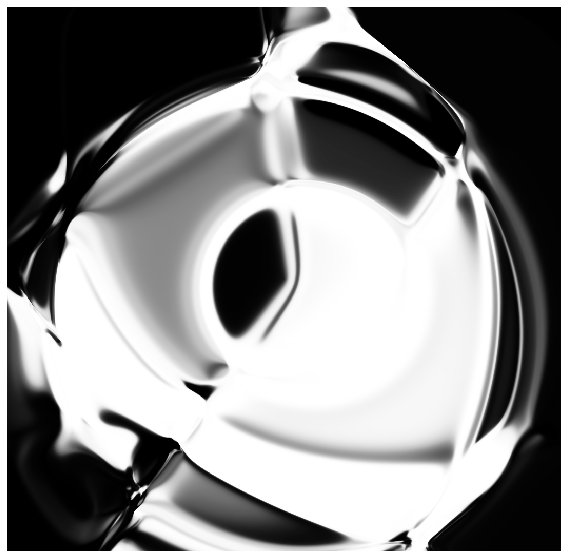

In [11]:
z1 = sampler.generate_z()
img_data = sampler.generate(z1)
sampler.show_image(img_data)

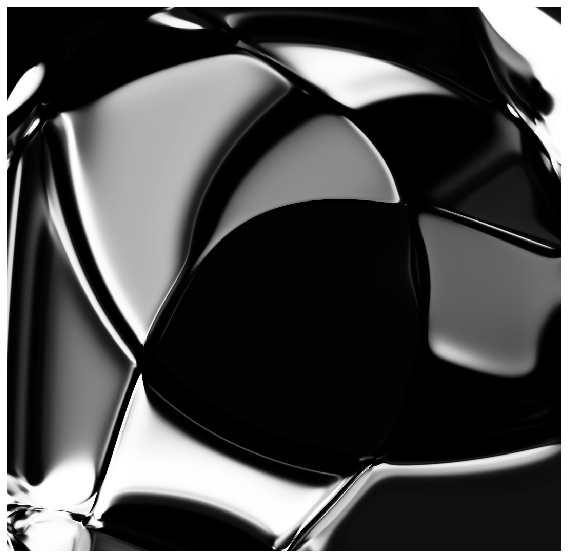

In [12]:
z2 = sampler.generate_z()
img_data = sampler.generate(z2)
sampler.show_image(img_data)

In [13]:
sampler.save_anim_gif(z1, z2, 'gif_bw.gif')

processing image 1
processing image 2
processing image 3
processing image 4
processing image 5
processing image 6
processing image 7
processing image 8
processing image 9
processing image 10
processing image 11
processing image 12
writing gif file...
saved!


# Implement: Color

We can even use the same latent vectors that we generated earlier for the black and white version.

In [0]:
sampler_color = Sampler(x_dim=1800, y_dim=1800, z_dim=8, c_dim=3, scale=15, net_size=32)

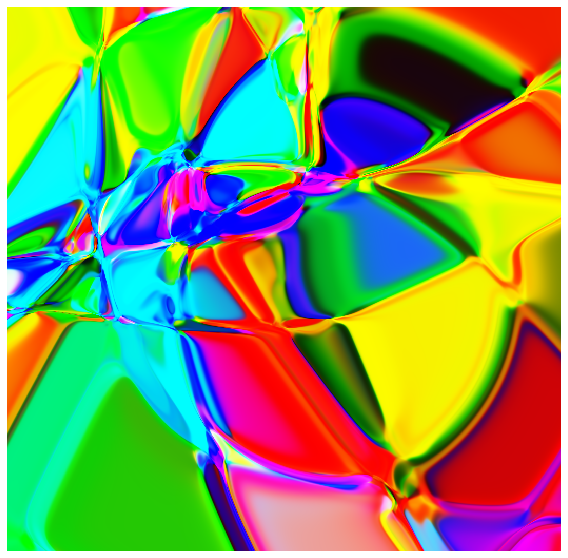

In [25]:
z3 = sampler_color.generate_z()
img_data = sampler_color.generate(z3)
sampler_color.show_image(img_data)

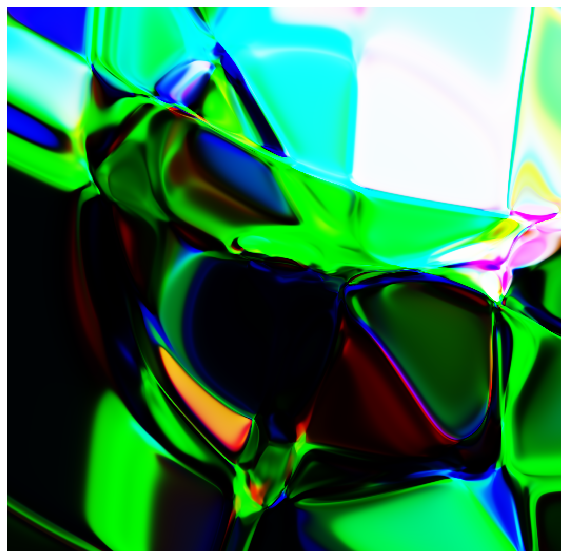

In [22]:
z4 = sampler_color.generate_z()
img_data = sampler_color.generate(z4)
sampler_color.show_image(img_data)

In [18]:
sampler_color.save_anim_gif(z3, z4, 'gif_color.gif', x_dim=1080, y_dim=1080)

processing image 1
processing image 2
processing image 3
processing image 4
processing image 5
processing image 6
processing image 7
processing image 8
processing image 9
processing image 10
processing image 11
processing image 12
writing gif file...
saved!
